In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# #Let's Examine Correlation between the series
# ###https://github.com/mikekeith52/scalecast-examples/blob/main/multivariate/multivariate.ipynb

import useful_functions as uf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
#from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2

In [88]:
# load the data
#file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/data_cleaned_RF.csv'
file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'
# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# define the target variable as the first column
target_variable = df_raw.columns[0]
# Convert all columns to float
df_raw = df_raw.astype('float64')

# Remove outliers
#remove_outliers_threshold = np.nan
remove_outliers_threshold = 0.20

In [89]:
# If we want to remove outliers
if not pd.isna(remove_outliers_threshold):
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else:
    df_cleaned = df_raw.copy()

# Fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

In [90]:
# Check if there is any collum with unique values and drop it
for column in df_adjusted.columns:
    if len(df_adjusted[column].unique()) == 1:
        df_adjusted.drop(column, axis=1, inplace=True)


In [91]:
# Define test and validation set sizes
val_size = 48 # 48 months or 4 years
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets
train_raw_total = df_adjusted.copy()[:-test_size] # This total trainning set will be used to train the final model
train_raw = train_raw_total[:-val_size]
val_raw = train_raw_total[-val_size:]
test_raw = df_adjusted.copy()[-test_size:]

# # FIll missing values
df_train = uf.fill_missing_values(train_raw)
df_val = uf.fill_missing_values(val_raw)
df_test = uf.fill_missing_values(test_raw)


In [92]:
# Let´s scale the dfs

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train)
scaled_val = scaler.transform(df_val)
scaled_test = scaler.transform(df_test)
# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_train.columns)
val = pd.DataFrame(scaled_val, columns=df_val.columns)
test = pd.DataFrame(scaled_test, columns=df_test.columns)
# Include the index in the train and test sets
train.index = df_train.index
val.index = df_val.index
test.index = df_test.index


Reshape your data

In [93]:
# Converting the series to samples
# We will use the past 12 months to predict the value in the horizon of 12 months
def createXY(dataset, n_past, n_future):
    dataX, dataY = [], []
    # Loop for the entire dataset
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)  # Past n months
        dataY.append(dataset.iloc[i + n_future - 1, 0])  #
    return np.array(dataX), np.array(dataY)

n_past = 12  # Number of past months to use
n_future = 12  # Forecast horizon

# Create the samples
X_train, Y_train = createXY(train, n_past, n_future)
X_val, Y_val = createXY(val, n_past, n_future)
X_test, Y_test = createXY(test, n_past, n_future)


### Let's train a simple model

In [94]:
# Build a basic RNN model
def build_rnn_model(input_shape, rnn_units=50, optimizer='adam', learning_rate=0.001, dropout_rate=0.2, alphas_l1_l2=0.01):
    # Define the optimizer with the learning rate
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # Initialize the RNN model
    model = Sequential()
    # Add a SimpleRNN layer
    model.add(SimpleRNN(units=rnn_units, 
                        return_sequences=True,
                        #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                        #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                        #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                        input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=100, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1)) # Add an output layer
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


rnn_units = 300
learning_rate = 0.0001
optimizer = 'rmsprop' # 'adam' or 'rmsprop'
epochs = 50
batch_size = 32
dropout_rate = 0.1
alphas_l1_l2 = 0.01

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the basic RNN model
model = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]), 
                              rnn_units=rnn_units, optimizer=optimizer, 
                              learning_rate=learning_rate, dropout_rate=dropout_rate)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=0
)

# Make predictions
predictions_scaled = model.predict(X_val)


g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


In [107]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 12, 300)        │       102,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,004 (1.09 MB)

 Trainable params: 142,501 (556.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,503 (556.66 KB)

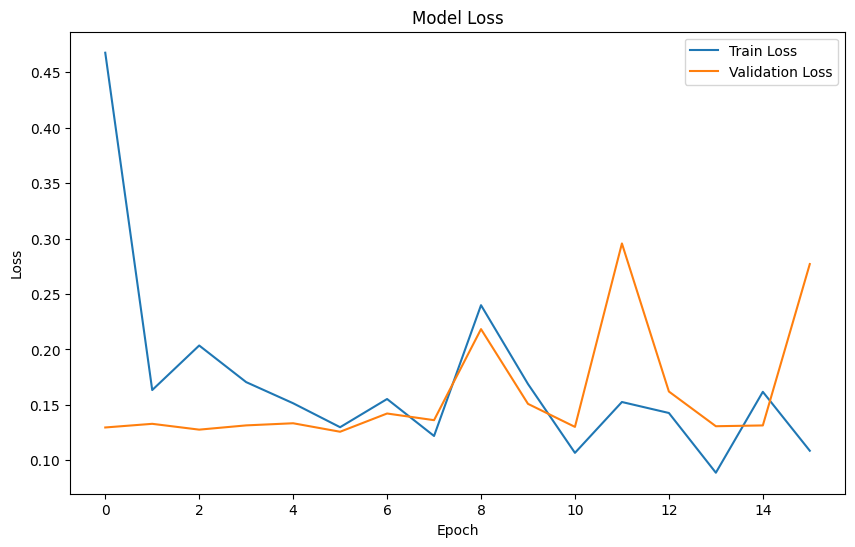

In [95]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [96]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_scaled_2d = predictions_scaled.reshape(-1, 1)
# Get the last timestep of X_val
X_val_last_timestep = X_val[:, -1, :]
# Replace the first column of X_val_last_timestep with the scaled predictions.
X_val_last_timestep[:, 0] = predictions_scaled_2d[:, 0]
# unscale the predictions
predictions_rescaled = scaler.inverse_transform(X_val_last_timestep)[:, 0]

# unscale the Y_val
#Y_val_2d = Y_val.reshape(-1, 1)
#Y_val_rescaled = scaler.inverse_transform(val.iloc[n_past:, :].values)[:, 0]
Y_val_rescaled = scaler.inverse_transform(val.iloc[-len(predictions_scaled):, :].values)[:, 0]

# Calculate the error
mape = mean_absolute_percentage_error(Y_val_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(Y_val_rescaled, predictions_rescaled))
mae = mean_absolute_error(Y_val_rescaled, predictions_rescaled)

print(f'MAPE RNN: {mape}')
print(f'RMSE RNN: {rmse}')
print(f'MAE RNN: {mae}')

MAPE RNN: 1.413191318511963
RMSE RNN: 17830.595703125
MAE RNN: 13663.0927734375


In [97]:
# Let's predict the test set using the best model
predictions_test_scaled = model.predict(X_test)
# Make predictions
#predictions_test_scaled = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [98]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_test_scaled_2d = predictions_test_scaled.reshape(-1, 1)
# Get the last timestep of X_test
X_test_last_timestep = X_test[:, -1, :]
# Replace the first column of X_test_last_timestep with the scaled predictions.
X_test_last_timestep[:, 0] = predictions_test_scaled_2d[:, 0]
# unscale the predictions
predictions_test_rescaled = scaler.inverse_transform(X_test_last_timestep)[:, 0]

# Let's convert the predictions and Y_test to a dataframe usind the index from test
predictions_test_df = pd.DataFrame(predictions_test_rescaled, index=test.index[-len(predictions_test_rescaled):], columns=[target_variable])

# Reverse the decomposition of the time series
#predictions = recompose_time_series(predictions_test_df, decomp_dict)
predictions = predictions_test_df.copy()
Y_test_ori = df_adjusted[-len(predictions):][target_variable]


In [99]:
# Calculate the error
mape_best_RNN = mean_absolute_percentage_error(Y_test_ori, predictions)
rmse_best_RNN = np.sqrt(mean_squared_error(Y_test_ori, predictions))
mae_best_RNN = mean_absolute_error(Y_test_ori, predictions)

print(f'MAPE best RNN: {mape_best_RNN}')
print(f'RMSE best RNN: {rmse_best_RNN}')
print(f'MAE best RNN: {mae_best_RNN}')

MAPE best RNN: 3.262701988220215
RMSE best RNN: 29916.5234375
MAE best RNN: 24862.546875


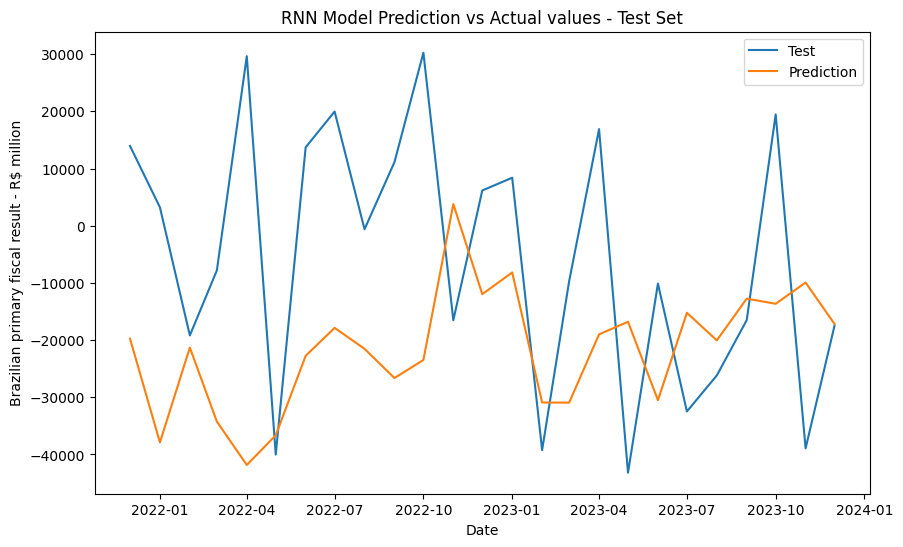

In [100]:
# Plot RNN best Model Forecast(static) vs Actuals

# Convert Y_test_rescaled to a dataframe using the test index
Y_test_rescaled_df = pd.DataFrame(Y_test_ori, index=Y_test_ori.index)
#Y_test_rescaled_df = pd.DataFrame(Y_test, index=test.index[n_past:])
# Change the column name to the target variable
Y_test_rescaled_df.columns = [target_variable]

uf.plot_prediction_vs_test(
    target_variable, 
    #train[target_variable], 
    Y_test_rescaled_df[target_variable],
    predictions,
    #predictions_test_rescaled, 
    'RNN Model Prediction vs Actual values - Test Set')

Let's forecast

In [101]:
# Adjust the index to datetime format
df_adjusted.index = pd.to_datetime(df_adjusted.index)

# New list to store the forecasts
monthly_forecasts = []

# Define a start date for the forecast
start_date = pd.Timestamp(year=2024, month=1, day=1)

for i in range(12):  # For each month in the next year
    # Define a end date for the forecast
    end_date = start_date - pd.DateOffset(months=13)
    # Define a start date 12 months before the end date
    start_date_12_months_before = end_date - pd.DateOffset(months=11)
    # Subset the dataset to get the data for the last 12 months
    data_for_prediction = df_adjusted.loc[start_date_12_months_before:end_date]
    # Scale the data
    data_for_prediction_scaled = scaler.transform(data_for_prediction)
    data_for_prediction_scaled_df = pd.DataFrame(data_for_prediction_scaled, columns=df_adjusted.columns) # convert to dataframe
    # Include the index in the train and test sets
    data_for_prediction_scaled_df.index = data_for_prediction.index
    
    # Prepare the data for the model
    X_predict = np.array([data_for_prediction_scaled_df]) # convert to numpy array
    # Predict the next month
    future_prediction_scaled = model.predict(X_predict)
    
    # Reverse the scaling
    temp_array = np.zeros((1, len(df_adjusted.columns))) # Create an array of zeros
    temp_array[0, 0] = future_prediction_scaled[0, 0] # Store the prediction in the first column

    # rescale the prediction
    future_prediction_rescaled = scaler.inverse_transform(temp_array)[0, 0]

    ### Compute confidence intervals
    # Compute squared errors for each prediction point
    predictions_array = predictions.values.flatten() # Convert the predictions to a 1D array
    squared_errors = (Y_test - predictions_array) ** 2
    rmse_errors = np.sqrt(squared_errors) # Take the square root of each squared error to get the RMSE for each point
    # Compute the standard error
    error_std = np.std(rmse_errors, axis=0)
    # Apply it to your forecasts
    lower_bound = future_prediction_rescaled - 1.96 * error_std # 95% confidence interval
    upper_bound = future_prediction_rescaled + 1.96 * error_std


    # Append the prediction to the list
    #monthly_forecasts.append(future_prediction_rescaled)
    # Store the prediction and bounds
    monthly_forecasts.append((future_prediction_rescaled, lower_bound, upper_bound))
    # Change the start date to the next month
    start_date += pd.DateOffset(months=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


### Forecast with decomposition

In [102]:
# # Get the trend and seasonal components for a specific series
# trend_component = decomp_dict[target_variable]['trend']
# seasonal_component = decomp_dict[target_variable]['seasonal']
# #residual_component = pd.DataFrame(residual_series[target_variable], index=residual_series.index)
# residual_component = residual_series





In [103]:
# # Adjust the index to datetime format
# df_adjusted.index = pd.to_datetime(df_adjusted.index)

# # New list to store the forecasts
# monthly_forecasts_v2 = []

# # Define a start date for the forecast
# start_date = pd.Timestamp(year=2024, month=1, day=1)

# for i in range(12):  # For each month in the next year
#     # Define a end date for the forecast
#     end_date = start_date - pd.DateOffset(months=13)
#     # Define a start date 12 months before the end date
#     start_date_12_months_before = end_date - pd.DateOffset(months=11)
#     # Subset the dataset to get the data for the last 12 months
#     data_for_prediction = residual_component.loc[start_date_12_months_before:end_date]
#     # Scale the data
#     data_for_prediction_scaled = scaler.transform(data_for_prediction)
#     data_for_prediction_scaled_df = pd.DataFrame(data_for_prediction_scaled, columns=df_adjusted.columns) # convert to dataframe
#     # Include the index in the train and test sets
#     data_for_prediction_scaled_df.index = data_for_prediction.index
    
#     # Prepare the data for the model
#     X_predict = np.array([data_for_prediction_scaled_df]) # convert to numpy array
#     # Predict the next month
#     future_prediction_scaled = model.predict(X_predict)
    
#     # Reverse the scaling
#     temp_array = np.zeros((1, len(df_adjusted.columns))) # Create an array of zeros
#     temp_array[0, 0] = future_prediction_scaled[0, 0] # Store the prediction in the first column

#     # rescale the prediction
#     future_prediction_rescaled = scaler.inverse_transform(temp_array)[0, 0]
#     # Append the prediction to the list
#     monthly_forecasts_v2.append(future_prediction_rescaled)
#     # Change the start date to the next month
#     start_date += pd.DateOffset(months=1)

In [104]:
# import numpy as np
# import pandas as pd
# from sklearn.linear_model import LinearRegression

# # Example: trend_component and seasonal_component are your trend and seasonality series up to Dec/2023

# # Extrapolate the Trend
# # Convert dates into a numerical format for linear regression
# date_nums = np.arange(len(trend_component)).reshape(-1, 1)

# # Fit linear regression to the trend component
# lin_reg = LinearRegression().fit(date_nums, trend_component.values)

# # Predict the trend for the next 12 months
# future_dates_num = np.arange(len(trend_component), len(trend_component) + 12).reshape(-1, 1)
# future_trend = lin_reg.predict(future_dates_num)

# # Project the Seasonality
# # Repeat the last known seasonal pattern for 2024
# last_year_seasonal = seasonal_component[-12:].values
# future_seasonal = np.tile(last_year_seasonal, 1)  # Assuming annual seasonality

# # Combine Residuals, Trend, and Seasonality for each month of 2024
# future_series = future_trend + future_seasonal + np.array(monthly_forecasts_v2)

# # Assuming monthly_forecasts is the list of predicted residuals you've already calculated


In [105]:
# Convert the forecasts to a DataFrame
# Get the last date of the test set
last_test_date = Y_test_rescaled_df.index[-1]
future_dates = pd.date_range(start=last_test_date + pd.DateOffset(months=1), periods=12, freq='MS')
monthly_forecasts_df = pd.DataFrame(monthly_forecasts, index=future_dates, columns=[target_variable, 'Lower Bound', 'Upper Bound'])

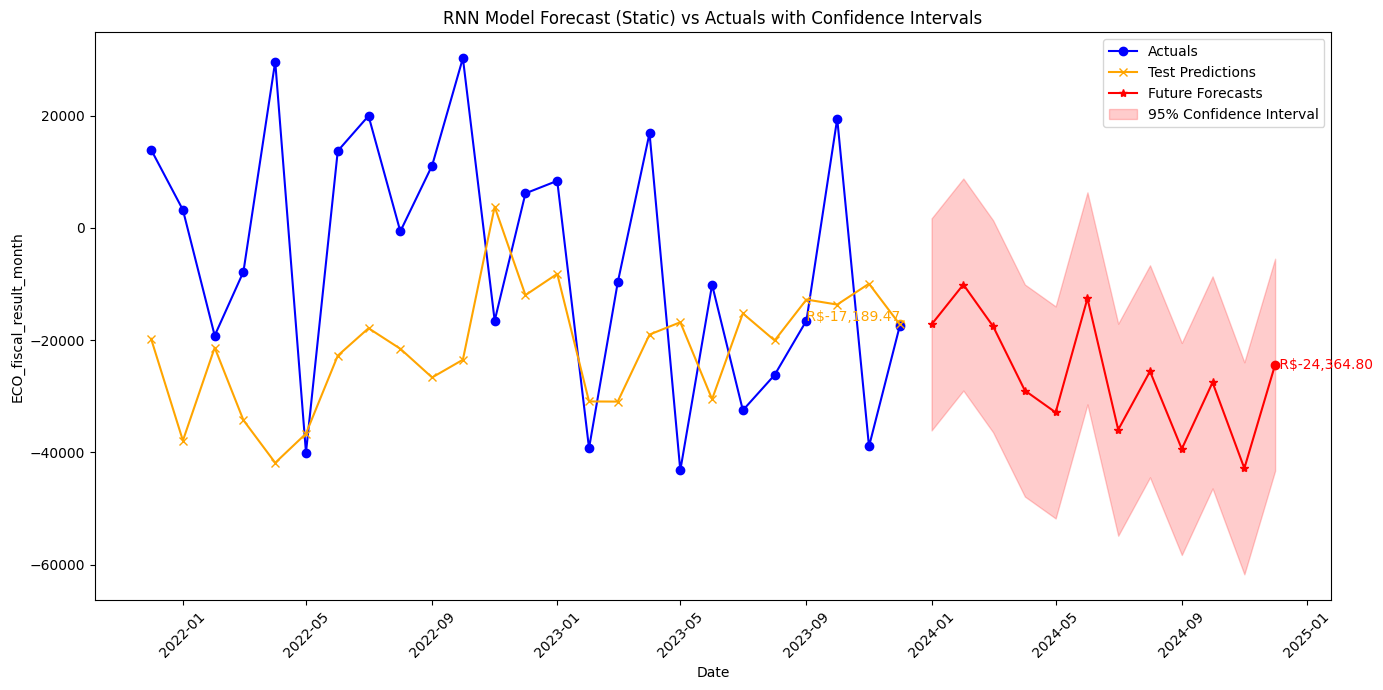

In [106]:
# Convert the monthly forecasts to a DataFrame
#monthly_forecasts = pd.DataFrame(monthly_forecasts, index=future_dates, columns=[target_variable])

# Convert future_series to a DataFrame
#future_series_df = pd.DataFrame(future_series, index=future_dates, columns=[target_variable])

# Plot the actuals, test predictions, and future forecasts
plt.figure(figsize=(14, 7))
# Actuals for the test set
#plt.plot(Y_test_rescaled_df.index, Y_test_rescaled_df[target_variable], label='Actuals', marker='o')
# Actuals for the test set
plt.plot(Y_test_rescaled_df.index, Y_test_rescaled_df[target_variable], label='Actuals', marker='o', color='blue')
# Predictions for the test set
plt.plot(predictions.index, predictions[target_variable], label='Test Predictions', marker='x', color='orange')

# Future forecasts with confidence intervals
plt.plot(monthly_forecasts_df.index, monthly_forecasts_df[target_variable], label='Future Forecasts', marker='*', color='red')

# Confidence intervals
plt.fill_between(monthly_forecasts_df.index, 
                 monthly_forecasts_df['Lower Bound'], 
                 monthly_forecasts_df['Upper Bound'], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Predictions for the test set
#plt.plot(predictions.index, predictions[target_variable], label='Test Predictions', marker='x')
# Future forecasts decomposing the original series from the last 12 months and them recomposing after the forecast
# plt.plot(future_series_df.index, future_series_df[target_variable], label='Future Forecasts - Decomposing', marker='*')
# Future forecasts based on the complete original series from the last 12 months
#plt.plot(future_series_df.index, monthly_forecasts, label='Future Forecasts - Complete Series', marker='*')

# Annotate the last predicted observation
last_predicted_date = predictions.index[-1]
last_predicted_value = predictions[target_variable].iloc[-1]
plt.scatter(last_predicted_date, last_predicted_value, color='orange')  # Highlight the last point
plt.text(last_predicted_date, last_predicted_value, f' R${last_predicted_value:,.2f}', color='orange', va='bottom', ha='right')

# # Annotate the last forecast observation - decomposing
# last_forecast_date = future_series_df.index[-1]
# last_forecast_value = future_series_df[target_variable].iloc[-1]
# plt.scatter(last_forecast_date, last_forecast_value, color='green')  # Highlight the last point
# plt.text(last_forecast_date, last_forecast_value, f' R${last_forecast_value:,.2f}', color='green', va='bottom', ha='right')

# Annotate the last forecast observation - Complete Series
last_forecast_date = monthly_forecasts_df.index[-1]
last_forecast_value = monthly_forecasts_df[target_variable].iloc[-1]
plt.scatter(last_forecast_date, last_forecast_value, color='red')  # Highlight the last point
plt.text(last_forecast_date, last_forecast_value, f' R${last_forecast_value:,.2f}', color='red', va='center', ha='left')

plt.title('RNN Model Forecast (Static) vs Actuals with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
